In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import math
import tensorflow as tf
import keras
from keras import optimizers, Sequential
from keras.models import Model
from keras.utils import plot_model
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint, TensorBoard
import numpy as np
from numpy import arange, sin, pi, random
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import scipy.integrate as integrate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from scipy.stats import pearsonr

np.random.seed(1234)  
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
%matplotlib inline

In [2]:
def gen_wave():
    """ Generate a synthetic data
    :return: the final data
    """
    t = np.arange(0.0, 100.0, 0.01)
    wave1 = sin(2 * 2 * pi * t)
    noise = random.normal(0, 0.2, len(t))
    wave1 = wave1 + noise
    print("wave1", len(wave1))
    wave2 = sin(2 * pi * t)
    print("wave2", len(wave2))
    t_rider = arange(0.0, 5.0, 0.01)
    wave3 = -2*sin(10 * pi * t_rider)
    print("wave3", len(wave3))
    insert = round(0.8 * len(t))
    wave1[insert:insert + 500] = wave1[insert:insert + 500] + wave3
    return wave1 - 2*wave2

def z_norm(result):
    result_mean = result.mean()
    result_std = result.std()
    result -= result_mean
    result /= result_std
    return result, result_mean

def get_split_prep_data(train_start, train_end,
                          test_start, test_end):
    data = gen_wave()
    print("Length of Data", len(data))

    # train data
    print ("Creating train data...")

    result = []
    for index in range(train_start, train_end - sequence_length):
        result.append(data[index: index + sequence_length])
    result = np.array(result)  # shape (samples, sequence_length)
    result, result_mean = z_norm(result)

    print ("Mean of train data : ", result_mean)
    print ("Train data shape  : ", result.shape)

    train = result[train_start:train_end, :]
    np.random.shuffle(train)  # shuffles in-place
    X_train = train[:, :-1]
    y_train = train[:, -1]

    # test data
    print ("Creating test data...")

    result = []
    for index in range(test_start, test_end - sequence_length):
        result.append(data[index: index + sequence_length])
    result = np.array(result)  # shape (samples, sequence_length)
    result, result_mean = z_norm(result)

    print ("Mean of test data : ", result_mean)
    print ("Test data shape  : ", result.shape)

    X_test = result[:, :-1]
    y_test = result[:, -1]

    print("Shape X_train", np.shape(X_train))
    print("Shape X_test", np.shape(X_test))

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    return X_train, y_train, X_test, y_test

def flatten(X):
    '''
    Flatten a 3D array.
    
    Input
    X            A 3D array for lstm, where the array is sample x sequence length x features.
    
    Output
    flattened_X  A 2D array, sample x features.
    '''
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)



def kde_sklearn(x, bandwidth=0.2, **kwargs):
	x_grid = np.linspace(x.min() - 0.9*x.min(), x.max() + x.max(), 500)
	"""Kernel Density Estimation with Scikit-learn"""
	kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
	kde_skl.fit(x[:, np.newaxis])
	# score_samples() returns the log-likelihood of the samples
	log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
	return np.exp(log_pdf), x_grid
   
def FindThreshold(x,h,p):
    tau=0
    x.sort() 
    for i in range(len(x)):
        int_K = integrate.quad(lambda s: (1/(h*np.sqrt(2*np.pi)))*np.exp(-0.5*(s-p)/h), (i-1)/len(x), i/len(x))
        tau=tau+int_K[0]*x[i]
    return tau




In [3]:


# train on first 7000 samples and test on next 3000 samples (has anomaly)
sequence_length = 11
DATA_SPLIT_PCT = 0.2
SEED = 123 #used to help randomly select the data points
batch_size = 50
epochs = 3
X_train,y_train, X_test, y_test = get_split_prep_data(0, 6999, 7000, 10000)
X_train_X, X_valid = train_test_split(X_train, test_size=DATA_SPLIT_PCT, random_state=SEED)
timesteps =  X_train.shape[1] # equal to the sequence_length
n_features =  X_train.shape[2] # 1



wave1 10000
wave2 10000
wave3 500
Length of Data 10000
Creating train data...
Mean of train data :  0.0044777924029005805
Train data shape  :  (6988, 11)
Creating test data...
Mean of test data :  0.0005497895275597763
Test data shape  :  (2989, 11)
Shape X_train (6988, 10)
Shape X_test (2989, 10)


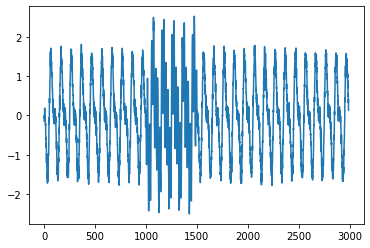

In [4]:
plt.plot(X_test[:,0])

In [5]:
import keras
import sklearn
from sklearn.model_selection import GridSearchCV
results = {}
for num_cells in [16, 32, 64,80,96]:
    for lr in [1e-4, 1e-3, 1e-2]:
            print('Running with', num_cells, 
                  'LSTM cells'
                  'and learning rate =', lr, '...')

            # build network
            lstm_autoencoder = Sequential()
            # Encoder
            lstm_autoencoder.add(LSTM(100, activation='relu', input_shape=(timesteps, n_features), return_sequences=True))
            lstm_autoencoder.add(LSTM(25, activation='relu', return_sequences=False))
            lstm_autoencoder.add(RepeatVector(timesteps))
            # Decoder
            lstm_autoencoder.add(LSTM(25, activation='relu', return_sequences=True))
            lstm_autoencoder.add(LSTM(100, activation='relu', return_sequences=True))
            lstm_autoencoder.add(TimeDistributed(Dense(n_features)))
            lstm_autoencoder.summary()
            adam = optimizers.Adam(lr)
            lstm_autoencoder.compile(loss='mse', optimizer=adam)
            cp = ModelCheckpoint(filepath="lstm_autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)
            tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)
            lstm_autoencoder_history = lstm_autoencoder.fit(X_train, X_train, 
                                                epochs=epochs, 
                                                batch_size=batch_size, 
                                                validation_data=(X_valid, X_valid),
                                                verbose=2, callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')]).history
            print("Predicting...")
            predicted_train = lstm_autoencoder.predict(X_train)
            predicted = lstm_autoencoder.predict(X_test)
            mse = np.mean(np.power(flatten(X_test) - flatten(predicted), 2), axis=1)
            mse_train = np.mean(np.power(flatten(X_train) - flatten(predicted_train), 2), axis=1)
            #KDE
            # use grid search cross-validation to optimize the bandwidth
            params = {'bandwidth': np.linspace(0, 0.5, 10)}
            grid = GridSearchCV(sklearn.neighbors.KernelDensity(), params, cv = 20)
            grid.fit(mse_train[:, None])
            h=grid.best_estimator_.bandwidth
            tau=FindThreshold(mse_train,h,0.56)
            y_test1=np.ones(X_test.shape[0])
            y_test1[999:1499]=-1
            y_scores=np.ones(X_test.shape[0])
            y_scores[(mse-tau)>0]=-1
            accuracy_kde = accuracy_score(y_test1, y_scores)
            #OCSVM
            e=X_train - predicted_train
            nsamples, nx, ny = e.shape
            d2_e = e.reshape((nsamples,nx*ny))
            from sklearn import svm
            clf = svm.OneClassSVM(nu=0.0055, kernel="rbf", gamma=1.5)
            clf.fit(d2_e)
            e_t=X_test - predicted
            nsamples, nx, ny = e_t.shape
            d2_e_t = e_t.reshape((nsamples,nx*ny))
            y_scores = clf.predict(d2_e_t)
            accuracy_svm = accuracy_score(y_test1, y_scores)
            accuracy= min(accuracy_svm,accuracy_kde)
            results[(num_cells, lr)] = {'accuracy': accuracy}       
val_results = {key: results[key]['accuracy'] for key in results.keys()}
num_cells, lr = min(val_results, key=val_results.get)
print('Best parameters:', num_cells, 
        'and learning rate =', lr)

#Best parameters: num_cells=64,  lr=0.01
#num_cells=64
#lr = 0.01

Running with 16 LSTM cellsand learning rate = 0.0001 ...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 100)           40800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 25)                12600     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 10, 25)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 25)            5100      
_________________________________________________________________
lstm_3 (LSTM)                (None, 10, 100)           50400     
_________________________________________________________________
time_distributed (TimeDistri (None, 10, 1)             101       
Total params: 109,001
Trainable params: 109,001
Non-trainable par

Epoch 2/3
140/140 - 3s - loss: 0.0738 - val_loss: 0.0904
Epoch 3/3
140/140 - 4s - loss: 0.0320 - val_loss: 0.0176
Predicting...
Running with 64 LSTM cellsand learning rate = 0.0001 ...
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 10, 100)           40800     
_________________________________________________________________
lstm_25 (LSTM)               (None, 25)                12600     
_________________________________________________________________
repeat_vector_6 (RepeatVecto (None, 10, 25)            0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 10, 25)            5100      
_________________________________________________________________
lstm_27 (LSTM)               (None, 10, 100)           50400     
_________________________________________________________________
t

140/140 - 11s - loss: 0.2463 - val_loss: 0.0359
Epoch 2/3
140/140 - 7s - loss: 0.0201 - val_loss: 0.0133
Epoch 3/3
140/140 - 6s - loss: 0.0131 - val_loss: 0.0128
Predicting...
Running with 96 LSTM cellsand learning rate = 0.0001 ...
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_48 (LSTM)               (None, 10, 100)           40800     
_________________________________________________________________
lstm_49 (LSTM)               (None, 25)                12600     
_________________________________________________________________
repeat_vector_12 (RepeatVect (None, 10, 25)            0         
_________________________________________________________________
lstm_50 (LSTM)               (None, 10, 25)            5100      
_________________________________________________________________
lstm_51 (LSTM)               (None, 10, 100)           50400     
__________________

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_60 (LSTM)               (None, 10, 128)           66560     
_________________________________________________________________
lstm_61 (LSTM)               (None, 32)                20608     
_________________________________________________________________
repeat_vector_15 (RepeatVect (None, 10, 32)            0         
_________________________________________________________________
lstm_62 (LSTM)               (None, 10, 32)            8320      
_________________________________________________________________
lstm_63 (LSTM)               (None, 10, 128)           82432     
_________________________________________________________________
time_distributed_15 (TimeDis (None, 10, 1)             129       
Total params: 178,049
Trainable params: 178,049
Non-trainable params: 0
_______________________________________________

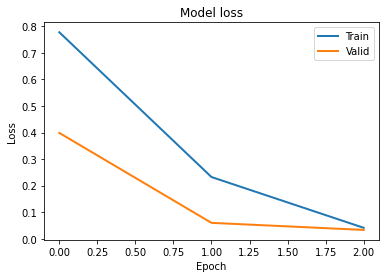

In [6]:
import keras
lstm_autoencoder = Sequential()

# Encoder
lstm_autoencoder.add(LSTM(num_cells*4, activation='relu', input_shape=(timesteps, n_features), return_sequences=True))
lstm_autoencoder.add(LSTM(num_cells, activation='relu', return_sequences=False))
lstm_autoencoder.add(RepeatVector(timesteps))
# Decoder
lstm_autoencoder.add(LSTM(num_cells, activation='relu', return_sequences=True))
lstm_autoencoder.add(LSTM(num_cells*4, activation='relu', return_sequences=True))
lstm_autoencoder.add(TimeDistributed(Dense(n_features)))

lstm_autoencoder.summary()

adam = optimizers.Adam(lr)
lstm_autoencoder.compile(loss='mse', optimizer=adam)

cp = ModelCheckpoint(filepath="lstm_autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)


lstm_autoencoder_history = lstm_autoencoder.fit(X_train, X_train, 
                                                epochs=epochs, 
                                                batch_size=batch_size, 
                                                validation_data=(X_valid, X_valid),
                                                verbose=2, callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')]).history
                                                
plt.plot(lstm_autoencoder_history['loss'], linewidth=2, label='Train')
plt.plot(lstm_autoencoder_history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()


Predicting...


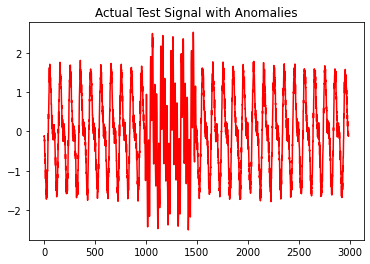

CPU times: user 3.83 s, sys: 2.85 s, total: 6.68 s
Wall time: 7.14 s


In [7]:
%%time
print("Predicting...")
predicted_train = lstm_autoencoder.predict(X_train)
predicted = lstm_autoencoder.predict(X_test)
#print("Reshaping predicted")
#predicted_train = np.reshape(predicted_train, (predicted_train.size,))
#predicted = np.reshape(predicted, (predicted.size,))

plt.figure()
plt.title("Actual Test Signal w/Anomalies")
plt.plot(y_train[:len(y_train)], 'b')

plt.figure()
plt.title("Squared Error")
mse = np.mean(np.power(flatten(X_test) - flatten(predicted), 2), axis=1)
plt.plot(mse, 'r')
mse_train = np.mean(np.power(flatten(X_train) - flatten(predicted_train), 2), axis=1)

import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.title("Actual Test Signal with Anomalies")
plt.plot(y_test[:len(y_test)], 'r')
plt.savefig('Epoch.png', dpi=1200)
plt.show()

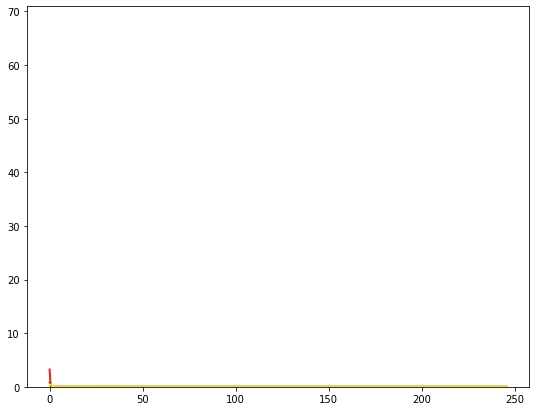

best bandwidth: 0.05555555555555555
Tau :  0.1421755534084586
Precision :  0.9453186467348544
Recall:  0.96544797107272
Accuracy :  0.9247239879558381
F1_score:  0.8588424419076908


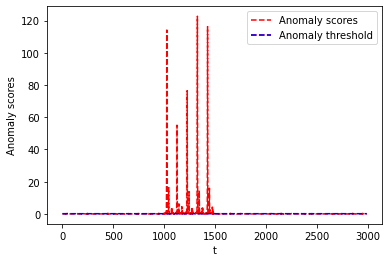

In [8]:
#KDE
from sklearn.neighbors import KernelDensity
def kde_sklearn(x, bandwidth=0.2, **kwargs):
	x_grid = np.linspace(x.min() - 0.9*x.min(), x.max() + x.max(), 500)
	"""Kernel Density Estimation with Scikit-learn"""
	kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
	kde_skl.fit(x[:, np.newaxis])
	# score_samples() returns the log-likelihood of the samples
	log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
	return np.exp(log_pdf), x_grid
   
def FindThreshold(x,h,p):
    tau=0
    x.sort() 
    for i in range(len(x)):
        int_K = integrate.quad(lambda s: (1/(h*np.sqrt(2*np.pi)))*np.exp(-0.5*(s-p)/h), (i-1)/len(x), i/len(x))
        tau=tau+int_K[0]*x[i]
    return tau

#Plot histogram
fig, ax2 = plt.subplots(figsize = (9,7))
ax2.hist(mse_train, bins = 100, alpha = 0.5, density = True)

#Plot KDE
pdf, mse_grid = kde_sklearn(mse, bandwidth = 0.5)
pdf2, mse_grid2 = kde_sklearn(mse, bandwidth = 0.1)
pdf3, mse_grid3 = kde_sklearn(mse, bandwidth = 0.9)
ax2.plot(mse_grid, pdf, alpha = 0.9, color = 'green', linewidth = 2.0)
ax2.plot(mse_grid2, pdf2, alpha = 0.9, color = 'red', linewidth = 2.0)
ax2.plot(mse_grid3, pdf3, alpha = 0.9, color = 'yellow', linewidth = 2.0)
plt.show()

# use grid search cross-validation to optimize the bandwidth
params = {'bandwidth': np.linspace(0, 0.5, 10)}
grid = GridSearchCV(KernelDensity(), params, cv = 20)
grid.fit(mse_train[:, None])

print("best bandwidth: {0}".format(grid.best_estimator_.bandwidth))
h=grid.best_estimator_.bandwidth
tau=FindThreshold(mse_train,h,0.56)

y_test1=np.ones(X_test.shape[0])
y_test1[999:1499]=-1
y_scores=np.ones(X_test.shape[0])
y_scores[(mse-tau)>0]=-1
precision = precision_score(y_test1, y_scores)
recall    = recall_score(y_test1, y_scores)
accuracy = accuracy_score(y_test1, y_scores)
f1 = f1_score(y_test1, y_scores, average='macro')
print ('Tau : ', tau)
print ('Precision : ', precision)
print ('Recall: ', recall)
print ('Accuracy : ', accuracy)
print ('F1_score: ', f1)
fig=plt.figure(4)
red_dot, white_cross =plt.plot(mse, 'r--', np.ones(len(mse))*tau, 'b--')
plt.xlabel('t')
plt.ylabel('Anomaly scores')
plt.legend([red_dot, (red_dot, white_cross)], ["Anomaly scores", "Anomaly threshold"])
plt.show()
fig.savefig('plot.png', dpi=1200)

In [9]:
%%time
#OCSVM
e=X_train - predicted_train
nsamples, nx, ny = e.shape
d2_e = e.reshape((nsamples,nx*ny))

from sklearn import svm
clf = svm.OneClassSVM(nu=0.0055, kernel="rbf", gamma=1.5)
clf.fit(d2_e)

e_t=X_test - predicted
nsamples, nx, ny = e_t.shape
d2_e_t = e_t.reshape((nsamples,nx*ny))
y_scores = clf.predict(d2_e_t)
precision = precision_score(y_test1, y_scores)
recall    = recall_score(y_test1, y_scores)
accuracy = accuracy_score(y_test1, y_scores)
f1 = f1_score(y_test1, y_scores, average='macro')
print ('Precision : ', precision)
print ('Recall: ', recall)
print ('Accuracy : ', accuracy)
print ('F1_score: ', f1)

Precision :  0.9911682055399438
Recall:  0.9919646444355162
Accuracy :  0.9859484777517564
F1_score:  0.9747410483617838
CPU times: user 48.7 ms, sys: 0 ns, total: 48.7 ms
Wall time: 152 ms
